# Modelo de Wilson-Cowan

---
### Referencia:

Wilson, H., and Cowan, J. (1972). Excitatory and inhibitory interactions in localized populations of model neurons. _Biophysical Journal_ **12**. doi: [10.1016/S0006-3495(72)86068-5](https://doi.org/10.1016/S0006-3495(72)86068-5)

---
# Configuración

In [ ]:
# @title Instalar e importar gadget de comentarios

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D4_T3_Bonus"

In [ ]:
# Importaciones
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm

In [ ]:
# @title Configuraciónes de Figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Funciones de Trazado

def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc, 'b', label='Población E')
  plt.plot(x, FI_inh, 'r', label='Población I')
  plt.legend(loc='lower right')
  plt.xlabel('x (u.a.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='Población E')
  ax1.plot(pars['range_t'], rI1, 'r', label='Población I')
  ax1.set_ylabel('Actividad')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE2, 'b', label='Población E')
  ax2.plot(pars['range_t'], rI2, 'r', label='Población I')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Actividad')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='Nuliclina E')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='Nuliclina I')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')
  plt.show()


def my_plot_nullcline(pars):
  Exc_null_rE = np.linspace(-0.01, 0.96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rI = np.linspace(-.01, 0.8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='Nuliclina E')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='Nuliclina I')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
  rE_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Resolver para I a lo largo de la grilla E desde dE/dt = 0.

  Espera:
  pars    : Diccionario de parámetros
  dx      : incremento de valores iniciales
  n       : n*n trayectorias
  mylabel : etiqueta para la leyenda

  Devuelve:
    figura de la trayector
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                      'Trayectorias de ejemplo \npara distintas condiciones iniciales')
  my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                    'Trayectoria de ejemplo \npara baja actividad')
  my_plot_trajectory(pars, 'm', [0.6, 0.6],
                    'Trayectoria de ejemplo \npara alta actividad')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
            drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
            angles='xy', scale_units='xy', scale=5., facecolor='c')

  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
          f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
          horizontalalignment='center', verticalalignment='bottom',
          rotation=rotation)

In [ ]:
# @title Funciones Auxiliares

def default_pars(**kwargs):
  pars = {}

  # Parámetros excitatorios
  pars['tau_E'] = 1.     # Escala de tiempo de la población E [ms]
  pars['a_E'] = 1.2      # Ganancia de la población E
  pars['theta_E'] = 2.8  # Umbral de la población E

  # Parámetros inhibitorios
  pars['tau_I'] = 2.0    # Escala de tiempo de la población I [ms]
  pars['a_I'] = 1.0      # Ganancia de la población I
  pars['theta_I'] = 4.0  # Umbral de la población I

  # Fuerza de conexión
  pars['wEE'] = 9.   # De E a E
  pars['wEI'] = 4.   # De I a E
  pars['wIE'] = 13.  # De E a I
  pars['wII'] = 11.  # De I a I

  # Entrada externa
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # parámetros de simulación
  pars['T'] = 50.        # Duración total de la simulación [ms]
  pars['dt'] = .1        # Paso de tiempo de la simulación [ms]
  pars['rE_init'] = 0.2  # Valor inicial de E
  pars['rI_init'] = 0.2  # Valor inicial de I

  # Parámetros externos si los hay
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector de puntos de tiempo discretizados [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Función de activación de la población, curva F-I

  Argumentos:
    x     : la entrada de la población
    a     : la ganancia de la función
    theta : el umbral de la función

  Devuelve:
    f     : la respuesta de activación de la población f(x) para la entrada x
  """

  # añadir la expresión de f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivada de la función de activación de la población.

  Argumentos:
    x     : la entrada de la población
    a     : la ganancia de la función
    theta : el umbral de la función

  Devuelve:
    dFdx  : Derivada de la función de activación de la población.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

def F_inv(x, a, theta):
  """
  Argumentos:
    x         : la entrada de la población
    a         : la ganancia de la función
    theta     : el umbral de la función

  Devuelve:
    F_inverse : valor de la función inversa
  """

  # Calcular Finverse (ln(x) se puede calcular como np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **otros_pars):
  """
  Resolver para rI a lo largo de rE desde drE/dt = 0.

  Argumentos:
    rE    : respuesta de la población excitatoria
    a_E, theta_E, wEE, wEI, I_ext_E : parámetros excitatorios de Wilson-Cowan
    Otros parámetros son ignorados

  Devuelve:
    rI    : valores de la población inhibitoria a lo largo de la nuliclina en rE
  """
  # calcular rI para las nuliclinas de E en rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Resolver para rE a lo largo de rI desde drI/dt = 0.

  Argumentos:
    rI    : respuesta de la población inhibitoria
    a_I, theta_I, wIE, wII, I_ext_I : parámetros excitatorios de Wilson-Cowan
    Otros parámetros son ignorados

  Devuelve:
    rE    : valores de la población excitatoria a lo largo de la nuliclina en rI
  """
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE

def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  # Compute the derivative of rE
  drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  # Compute the derivative of rI
  drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  return drEdt, drIdt

def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E population
    drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI

Las funciones auxiliares incluían:

- Diccionario de parámetros: `default_pars(**kwargs)`. Puedes usar:
   - `pars = default_pars()` para obtener todos los parámetros, y luego puede ejecutar `print(pars)` para verificar estos parámetros.
   - `pars = default_pars(T=T_sim, dt=time_step)` para establecer un tiempo de simulación y un paso de tiempo diferentes
   - Después de `pars = default_pars()`, use `par['New_para'] = value` para agregar un nuevo parámetro con su valor
   - Pasar a funciones que acepten parámetros individuales con `func(**pars)`
- Curva F-I: `F(x, a, theta)`
- Derivada de la curva F-I: `dF(x, a, theta)`
- Inversa de la curva F-I: `F_inv`
- Cálculos de línea nula: `get_E_nullcline`, `get_I_nullcline`
- Derivadas de variables E/I: `EIderivs`
- Simular el modelo Wilson-Cowan: `simulate_wc`

---
# Puntos fijos, análisis de estabilidad y ciclos límite en el modelo Wilson-Cowan

## Sección 1.1: Puntos Fijos del sistema E/I

Los puntos de intersección de las dos curvas de nulaclina son los puntos fijos del modelo de Wilson-Cowan.

$$\tau_E\dot r_E = -r_E + F_E(w_{EE}r_E - w_{IE}r_I +I_{ext}^E)$$
$$\tau_I\dot r_I = -r_I + F_E(w_{EI}r_E - w_{II}r_I +I_{ext}^I)$$

En la parte de "Configuración" pueden ver cómo definimos las funciones de activación y el método de simulación (es un Euler adelantado, como en la notebook anterior)

En el siguiente ejercicio, encontraremos las coordenadas de todos los puntos fijos para un conjunto dado de parámetros.

Usaremos dos funciones, similares a las que vimos en el notebook anterior, que utilizan un algoritmo de búsqueda de raíces para encontrar los puntos fijos del sistema con poblaciones excitadoras e inhibidoras.

In [ ]:
# @title Funciones `my_fp` y `check_fp`*

def my_fp(pars, rE_init, rI_init):
  """
  Utilizar la función opt.root para resolver las Ecuaciones (2)-(3) desde valores iniciales
  """

  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI']
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

  # definir la mano derecha de las ecuaciones de Wilson-Cowan
  def my_WCr(x):

    rE, rI = x
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
    y = np.array([drEdt, drIdt])

    return y

  x0 = np.array([rE_init, rI_init])
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
  """
  Verificar si (drE/dt)^2 + (drI/dt)^2 < mytol

  Argumentos:
    pars    : Diccionario de parámetros
    fp      : valor del punto fijo
    mytol   : tolerancia, por defecto 10^{-6}

  Devuelve :
    Si es un punto fijo correcto: Verdadero/Falso
  """

  drEdt, drIdt = EIderivs(x_fp[0], x_fp[1], **pars)

  return drEdt**2 + drIdt**2 < mytol

# help(my_fp)

### Ppuntos fijos del modelo de Wilson-Cowan

Este es un código ejemplo para encontrar los puntos fijos del sistema (es decir, las intersecciones entre nulclinas)

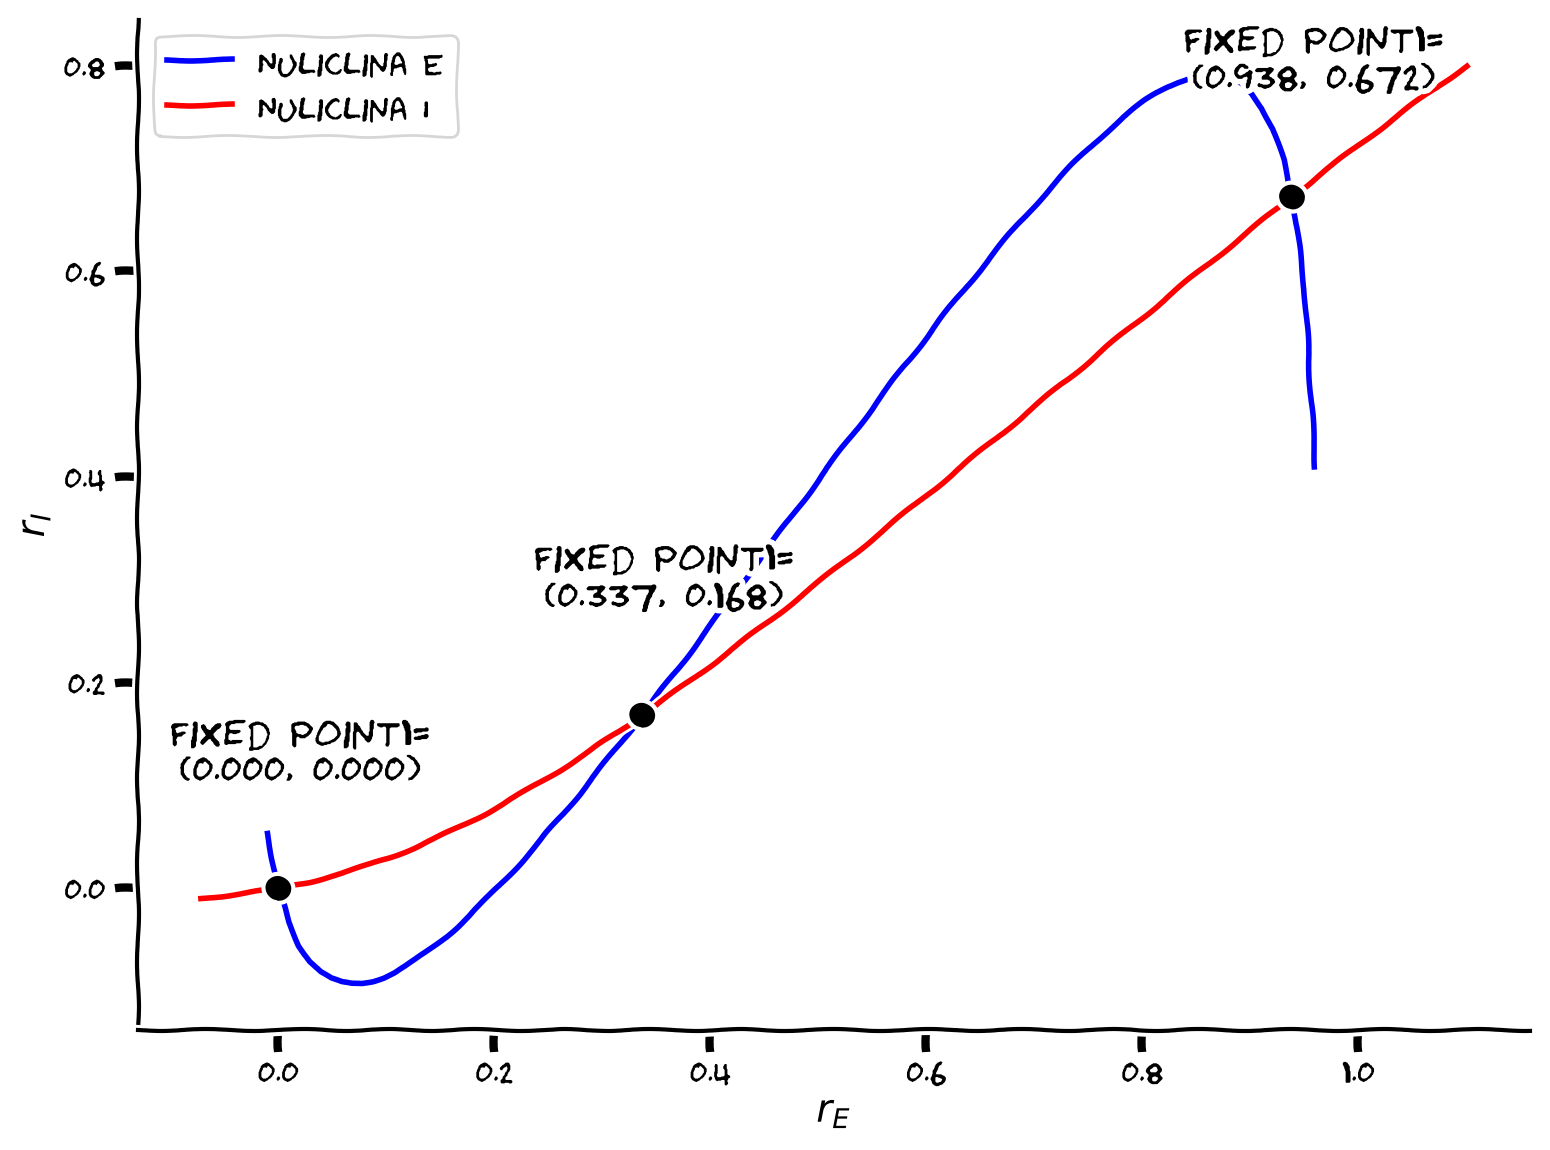

In [ ]:
pars = default_pars()

with plt.xkcd():
  my_plot_nullcline(pars)

  # Encuentra el primer punto fijo
  x_fp_1 = my_fp(pars, 0.1, 0.1)
  if check_fp(pars, x_fp_1):
    plot_fp(x_fp_1)

  # Encuentra el segundo punto fijo
  x_fp_2 = my_fp(pars, 0.3, 0.3)
  if check_fp(pars, x_fp_2):
    plot_fp(x_fp_2)

  # Encuentra el tercero punto fijo
  x_fp_3 = my_fp(pars, 0.8, 0.6)
  if check_fp(pars, x_fp_3):
    plot_fp(x_fp_3)

### Matriz jacobiana para el modelo de Wilson-Cowan

Usamos `dF(x,a,theta)` definida en las `Funciones auxiliares` para calcular la derivada de la curva F-I.

In [ ]:
def get_eig_Jacobian(fp,
                     tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
                     tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """Calcule los valores propios de la matriz jacobiana de Wilson-Cowan en un punto fijo."""
  # Inicialización
  rE, rI = fp
  J = np.zeros((2, 2))

  # Calcular los cuatro elementos de la matriz jacobiana.
  J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E,
                           a_E, theta_E)) / tau_E

  J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E,
                       a_E, theta_E)) / tau_E

  J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I,
                      a_I, theta_I)) / tau_I

  J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I,
                           a_I, theta_I)) / tau_I

  # Calcular y devolver los valores propios.
  evals = np.linalg.eig(J)[0]
  return evals


# Calcular los valores propios del jacobiano
eig_1 = get_eig_Jacobian(x_fp_1, **pars)
eig_2 = get_eig_Jacobian(x_fp_2, **pars)
eig_3 = get_eig_Jacobian(x_fp_3, **pars)

print(eig_1, 'Punto estable')
print(eig_2, 'Punto inestable')
print(eig_3, 'Punto estable')

[-0.62338386+0.13110957j -0.62338386-0.13110957j] Punto estable
[ 1.05720798 -0.87266898] Punto inestable
[-0.95956219 -1.42197413] Punto estable


Como es evidente, los puntos fijos estables corresponden a los autovalores negativos, mientras que los puntos inestables corresponden al menos a un autovalor positivo.

El signo de los valores propios está determinado por la conectividad (interacción) entre las poblaciones excitadoras e inhibidoras.

A continuación investigamos el efecto de $w_{EE}$ sobre las líneas nulas y los valores propios del sistema dinámico.

\* _El cambio crítico se conoce como **bifurcación en forma de horquilla**_.

## Bifurcaciones en el sistema debido a `wEE`

### Demostración interactiva 1.3: la posición de las líneas nulas en el plano de fase cambia con los valores de los parámetros

¿Cómo se mueven las líneas nulas para diferentes valores del parámetro $w_{EE}$? ¿Qué significa esto para los puntos fijos y la actividad del sistema?

In [ ]:
# @title Widget para variar parametro `wEE`

@widgets.interact(
    wEE=widgets.FloatSlider(6., min=6., max=10., step=0.01)
)

def plot_nullcline_diffwEE(wEE):
  """
    trazar inclinaciones nulas para diferentes valores de wEE
  """

  pars = default_pars(wEE=wEE)

  # trazar la E, I nulas
  Exc_null_rE = np.linspace(-0.01, .96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)

  Inh_null_rI = np.linspace(-.01, .8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12, 5.5))
  plt.subplot(121)
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nulclina')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nulclina')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')

  plt.subplot(222)
  pars['rE_init'], pars['rI_init'] = 0.2, 0.2
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E poblacion', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I poblacion', clip_on=False)
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E/I actividad\npara distintas condiciones iniciales',
            fontweight='bold')

  plt.subplot(224)
  pars['rE_init'], pars['rI_init'] = 0.4, 0.1
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E poblacion', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I poblacion', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=6.0, description='wEE', max=10.0, min=6.0, step=0.01), Output()), _dom…

También podemos investigar el efecto de diferentes $w_{EI}$, $w_{IE}$, $w_{II}$, $\tau_{E}$, $\tau_{I}$ y $I_{E). }^{\text{ext}}$ sobre la estabilidad de puntos fijos. Además, también podemos considerar la perturbación de los parámetros de la curva de ganancia $F(\cdot)$.

## Ciclo límite - Oscilaciones

Para algunos valores de términos de interacción ($w_{EE}, w_{IE}, w_{EI}, w_{II}$), los autovalores pueden volverse complejos. Cuando al menos un par de autovalores es complejo, surgen oscilaciones.
La estabilidad de las oscilaciones está determinada por la parte real de los autovalores. El tamaño de la parte compleja determina la frecuencia de las oscilaciones.

Por ejemplo, si usamos un conjunto diferente de parámetros, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, y $I_{E}^{\text{ext}}=0.8$, ¡entonces vemos que la actividad poblacional E e I comienza a oscilar!

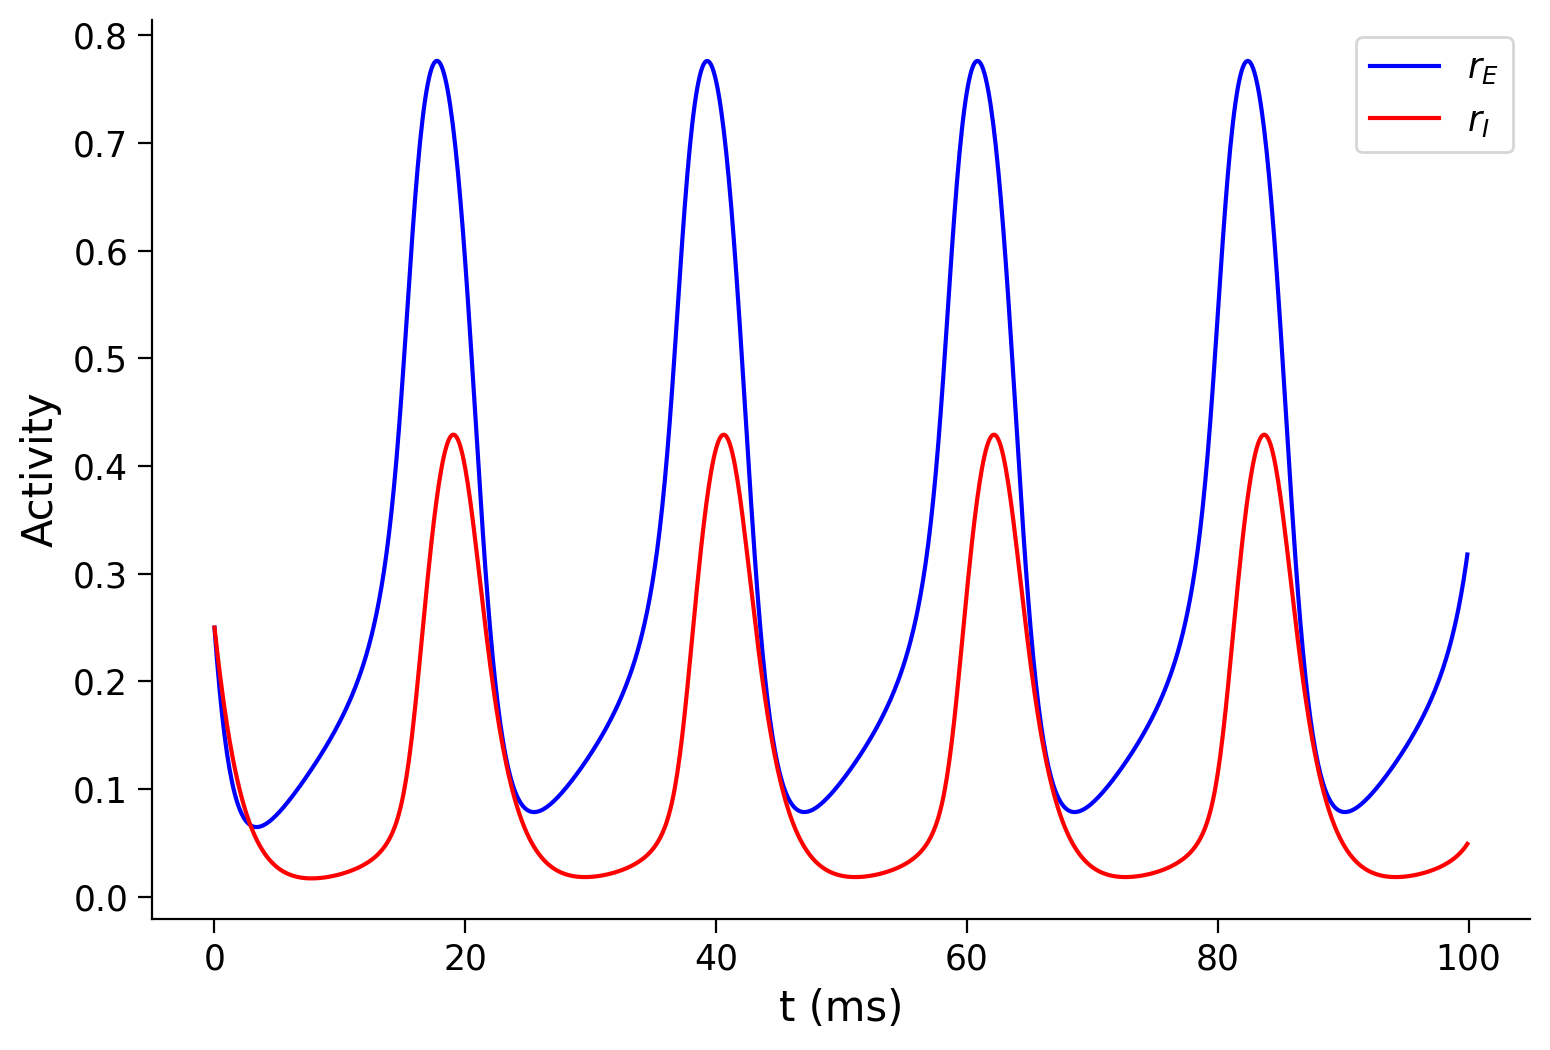

In [ ]:
# @title Ciclo Límite

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['rE_init'], pars['rI_init'] = 0.25, 0.25

rE, rI = simulate_wc(**pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
plt.xlabel('t (ms)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

También podemos entender las oscilaciones del comportamiento de la población utilizando el plano de fase. Al trazar un conjunto de trayectorias con diferentes estados iniciales, podemos ver que estas trayectorias se moverán en un círculo en lugar de converger a un punto fijo. Este círculo se llama "ciclo límite" y muestra las oscilaciones periódicas del comportamiento de la población $E$ e $I$ bajo algunas condiciones.

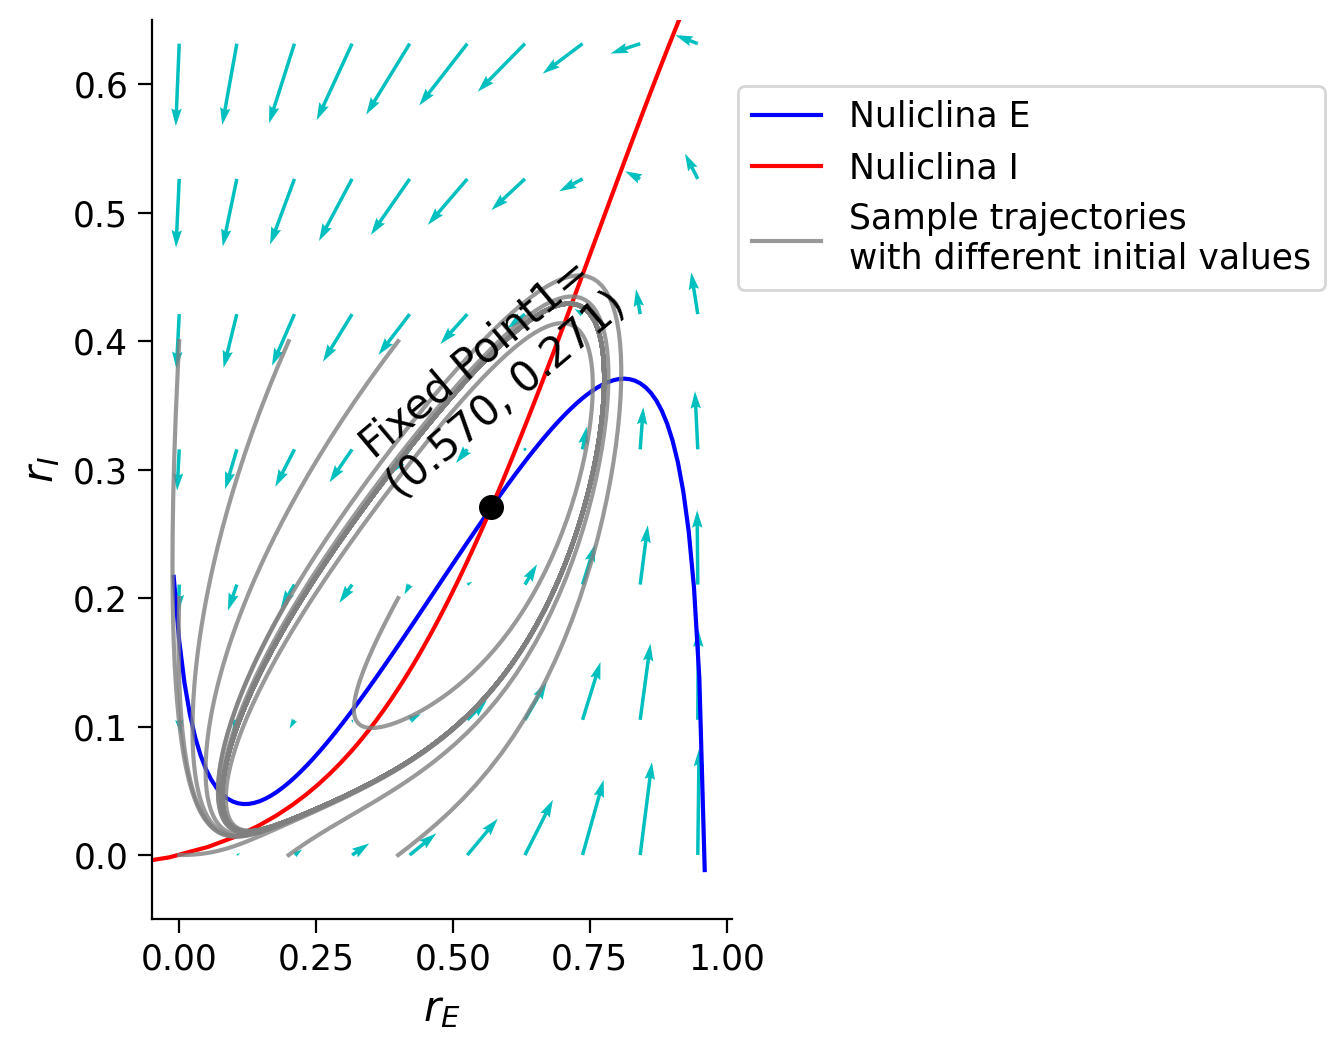

In [ ]:
# @markdown Ejecutar para visualizar el plano de fase.

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8


plt.figure(figsize=(7, 5.5))
my_plot_nullcline(pars)

# Encuentra el punto fijo correcto
x_fp_1 = my_fp(pars, 0.8, 0.8)
if check_fp(pars, x_fp_1):
  plot_fp(x_fp_1, position=(0, 0), rotation=40)

my_plot_trajectories(pars, 0.2, 3,
                      'Sample trajectories \nwith different initial values')

my_plot_vector(pars)

plt.legend(loc=[1.01, 0.7])
plt.xlim(-0.05, 1.01)
plt.ylim(-0.05, 0.65)
plt.show()

### Variación de los parámetros perturba la trayectoria del Ciclo límite

De los ejemplos anteriores, el cambio de los parámetros del modelo cambia la forma de las inclinaciones nulas y, en consecuencia, el comportamiento de las poblaciones $E$ e $I$ de puntos fijos estables a oscilaciones. Sin embargo, la forma de las nulas no puede determinar completamente el comportamiento de la red. El campo vectorial también importa. Para demostrar esto, vemos en la siguiente celda el efecto de las constantes temporales en el comportamiento de la población. Al cambiar $\tau_I$, las líneas nulas no cambian, pero el comportamiento de la red cambia sustancialmente desde un estado estable a oscilaciones con diferentes frecuencias.

Un cambio tan dramático en el comportamiento del sistema se conoce como **bifurcación**.

<br>
Ejecute el siguiente código para comprobar esto.

In [ ]:
# @title ¡La constante temporal inhibitoria $\tau_I$ es la responsable de la bifurcación entre el ciclo límite y el punto estable!


@widgets.interact(
    tau_i=widgets.FloatSlider(1.5, min=0.2, max=3., step=.1)
)


def time_constant_effect(tau_i=0.5):

  pars = default_pars(T=100.)
  pars['wEE'], pars['wEI'] = 6.4, 4.8
  pars['wIE'], pars['wII'] = 6.0, 1.2
  pars['I_ext_E'] = 0.8

  pars['tau_I'] = tau_i

  Exc_null_rE = np.linspace(0.0, .9, 100)
  Inh_null_rI = np.linspace(0.0, .6, 100)

  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12.5, 5.5))

  plt.subplot(121)  # líneas nulas
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline', zorder=2)
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline', zorder=2)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')

  # punto fijo
  x_fp_1 = my_fp(pars, 0.5, 0.5)
  plt.plot(x_fp_1[0], x_fp_1[1], 'ko', zorder=2)

  eig_1 = get_eig_Jacobian(x_fp_1, **pars)

  # trayectorias
  for ie in range(5):
    for ii in range(5):
      pars['rE_init'], pars['rI_init'] = 0.1 * ie, 0.1 * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      plt.plot(rE_tj, rI_tj, 'k', alpha=0.3, zorder=1)

  # campo vectorial
  EI_grid_E = np.linspace(0., 1.0, 20)
  EI_grid_I = np.linspace(0., 0.6, 20)
  rE, rI = np.meshgrid(EI_grid_E, EI_grid_I)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
              drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
              angles='xy', scale_units='xy', scale=10, facecolor='c')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)

  plt.subplot(122)  # muestra de trayectorias E/I
  pars['rE_init'], pars['rI_init'] = 0.25, 0.25
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.title(r'$\tau_I=$'+'%.1f ms' % tau_i)
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=1.5, description='tau_i', max=3.0, min=0.2), Output()), _dom_classes=(…

Tanto $\tau_E$ como $\tau_I$ aparecen en el jacobiano de la red de dos poblaciones (ecuación 7). Entonces aquí parece que al aumentar $\tau_I$ los valores propios correspondientes al punto fijo estable se vuelven complejos.

Intuitivamente, cuando $\tau_I$ es más pequeño, la actividad inhibidora cambia más rápido que la actividad excitadora. A medida que la inhibición excede un cierto valor, una inhibición alta inhibe la población excitadora, pero eso a su vez significa que la población inhibidora recibe una entrada menor (de la conexión exc.). Entonces la inhibición disminuye rápidamente. Pero esto significa que la excitación se recupera... y así sucesivamente...